# Finding a Circuit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("/workspace/circuit-finder")

In [3]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"

# Import stuff
import torch as t
from torch import Tensor
import numpy as np
import einops
import eindex
from tqdm.notebook import tqdm_notebook
import plotly.express as px
import plotly.graph_objects as go
import webbrowser
import functools
import re
import itertools

from jaxtyping import Float, Int, Bool
from typing import List, Union, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
import copy

from IPython.display import display, HTML

from rich.table import Table, Column
from rich import print as rprint

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache, FactoredMatrix
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

def concat_lists(list_of_lists):
    return functools.reduce(lambda x, y: x+y, list_of_lists)

update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor"}

def imshow(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "facet_labels" in kwargs_pre:
        facet_labels = kwargs_pre.pop("facet_labels")
    else:
        facet_labels = None
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label

    fig.show(renderer)

def line(tensor: Union[t.Tensor, List[t.Tensor]], renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "xaxis_tickvals" in kwargs_pre:
        tickvals = kwargs_pre.pop("xaxis_tickvals")
        kwargs_post["xaxis"] = dict(
            tickmode = "array",
            tickvals = kwargs_pre.get("x", np.arange(len(tickvals))),
            ticktext = tickvals
        )
    y = utils.to_numpy(tensor) if isinstance(tensor, t.Tensor) else list(map(utils.to_numpy, tensor))
    px.line(y=y, **kwargs_pre).update_layout(**kwargs_post).show(renderer)

def scatter(x, y, renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    add_line = None
    if "add_line" in kwargs:
        add_line = kwargs.pop("add_line")
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    fig = px.scatter(y=y, x=x, **kwargs_pre).update_layout(**kwargs_post)
    if add_line is not None:
        xrange = fig.layout.xaxis.range or [x.min(), x.max()]
        yrange = fig.layout.yaxis.range or [y.min(), y.max()]
        add_line = add_line.replace(" ", "")
        if add_line in ["x=y", "y=x"]:
            fig.add_trace(go.Scatter(mode='lines', x=xrange, y=xrange, showlegend=False))
        elif re.match("(x|y)=", add_line):
            try: c = float(add_line.split("=")[1])
            except: raise ValueError(f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c.")
            x, y = ([c, c], yrange) if add_line[0] == "x" else (xrange, [c, c])
            fig.add_trace(go.Scatter(mode='lines', x=x, y=y, showlegend=False))
        else:
            raise ValueError(f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c.")
    fig.show(renderer)

def bar(tensor, renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    px.bar(y=utils.to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/accelerate/utils/imports.py:274: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


In [4]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [5]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.paper.run_leap_experiment_batched import LeapExperimentResult

def load_result(
    dataset_name: str, threshold: float, sweep_name: str
) -> LeapExperimentResult:
    save_dir = (
        ProjectDir
        / "results"
        / sweep_name
        / f"dataset={dataset_name}_threshold={threshold}"
    )

    with open(save_dir / "result.pkl", "rb") as file:
        result = pickle.load(file)

    return result

result = load_result("docstring_prompts", 0.01, "corrupt_keep_error")

In [6]:
import torch

batch = result.batch
print(batch)

clean_tokens = batch.clean
answer_tokens = torch.cat([batch.answers, batch.wrong_answers], dim=-1)
corrupted_tokens = batch.corrupt
print(answer_tokens.shape)

clean_str = model.to_string(clean_tokens[0])
answer_str = model.to_string(batch.answers[0])
wrong_answer_str = model.to_string(batch.wrong_answers[0])
corrupted_str = model.to_string(corrupted_tokens[0])

print(clean_str)
print(answer_str, answer_str.startswith(" "))
print(wrong_answer_str, wrong_answer_str.startswith(" "))
print(corrupted_str)

PromptPairBatch(key=1772980813462012587, batch_diverge_idx=11, clean=tensor([[50256,   198,  4299,  3084,     7,   944,    11,  4235,    11,  7177,
            11,  2482,    11,  3124,    11, 31456,    11,  2560,  2599,   198,
           220,   220,   220, 37227,  6063,  1907,  6623,   628,   220,   220,
           220,  1058, 17143,  2482,    25,  2700, 11898,   198,   220,   220,
           220,  1058, 17143,  3124,    25,  1803,  8716,   198,   220,   220,
           220,  1058, 17143]], device='cuda:0'), corrupt=tensor([[50256,   198,  4299,  3084,     7,   944,    11,  4235,    11,  7177,
            11,  2779,    11,  3128,    11,   869,    11,  2560,  2599,   198,
           220,   220,   220, 37227,  6063,  1907,  6623,   628,   220,   220,
           220,  1058, 17143,  2438,    25,  2700, 11898,   198,   220,   220,
           220,  1058, 17143, 10139,    25,  1803,  8716,   198,   220,   220,
           220,  1058, 17143]], device='cuda:0'), answers=tensor([[31456]], device=

In [43]:
from circuit_finder.core.types import get_node_name, parse_node_name, get_hook_name 

nodes_of_interest = {
    "4-attn-17930": get_node_name("attn", 4, 14, 17930),
    "5-attn-27535": get_node_name("attn", 5, 43, 27353),
    "7-mlp-9600": get_node_name("mlp", 7, 15, 9600),
    "7-attn-15172": get_node_name("attn", 7, 52, 15172),
    "8-mlp-10087": get_node_name("mlp", 8, 52, 10087),
    "9-attn-9260": get_node_name("attn", 9, 52, 9260),
}

In [44]:
labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

In [45]:
import torch
from circuit_finder.core.types import get_node_name, parse_node_name, get_hook_name 
from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders, filter_sae_acts_and_errors


for name, node in nodes_of_interest.items():
    module_name, layer_idx, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_hook_name(module_name, layer_idx)

    # Compare the clean vs corrupt node act at every layer position. 
    with torch.no_grad():
        with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
            _, clean_sae_cache = model.run_with_cache(clean_tokens, names_filter = filter_sae_acts_and_errors)
            _, corrupt_sae_cache = model.run_with_cache(corrupted_tokens, names_filter = filter_sae_acts_and_errors)


    clean_node_act = clean_sae_cache[hook_name][0, :, feature_idx]
    corrupt_node_act = corrupt_sae_cache[hook_name][0, :, feature_idx]
    clean_node_val = clean_node_act[token_idx].item()
    corrupt_node_val = corrupt_node_act[token_idx].item()

    stacked_acts = torch.stack([clean_node_act, corrupt_node_act], dim = 0)

    imshow(
        stacked_acts,
        x = labels, 
        # labels={"y": "Layer", "x": "Head"},
        title=f"Clean vs Corrupt Activation for node {node}",
    )


In [46]:
def logits_to_ave_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], answer_tokens: Float[Tensor, "batch 2"], per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''
    last_token_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    correct_logits = eindex.eindex(last_token_logits, answer_tokens[:, 0], "batch [batch]")
    incorrect_logits = eindex.eindex(last_token_logits, answer_tokens[:, 1], "batch [batch]")

    logits: Float[Tensor, "batch"] = correct_logits - incorrect_logits
    if per_prompt:
      return logits
    else:
      return logits.mean()

In [47]:
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 8.2522
Corrupted logit diff: 0.8525


In [48]:
def normalized_metric(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> float:
    '''
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    '''
    last_token_logits = logits[:, -1, :]
    correct_logit = eindex.eindex(last_token_logits, answer_tokens[:, 0], "batch [batch]")
    incorrect_logit = eindex.eindex(last_token_logits, answer_tokens[:, 1], "batch [batch]")
    logit_diff: Float[Tensor, "batch"] = correct_logit - incorrect_logit
    logit_diff = logit_diff.mean()

    return (logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

In [49]:
def patch_hook(act, hook, token_idx, feature_idx, value):
    act[:, token_idx, feature_idx] = value
    return act


def get_node_patching_plot(node, model, tokens, values):
    metrics = []
    module_name, layer_idx, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_hook_name(module_name, layer_idx)
    with torch.no_grad():
        with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
            for value in values:
                hook_fn = partial(
                    patch_hook,
                    token_idx=token_idx,
                    feature_idx=feature_idx,
                    value=value,
                )
                with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):
                    patched_logits = model(tokens)
                    metric = normalized_metric(patched_logits)
                    metrics.append(metric.item())

    return values, metrics

# Denoising Results

In [61]:
results = {}

for name, node in nodes_of_interest.items():
    values, metrics = get_node_patching_plot(node, model, corrupted_tokens, np.arange(10) * 10)
    results[name] = (values, metrics)

<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param


Text(0.5, 0.98, 'Activation patching on corrupt prompt')

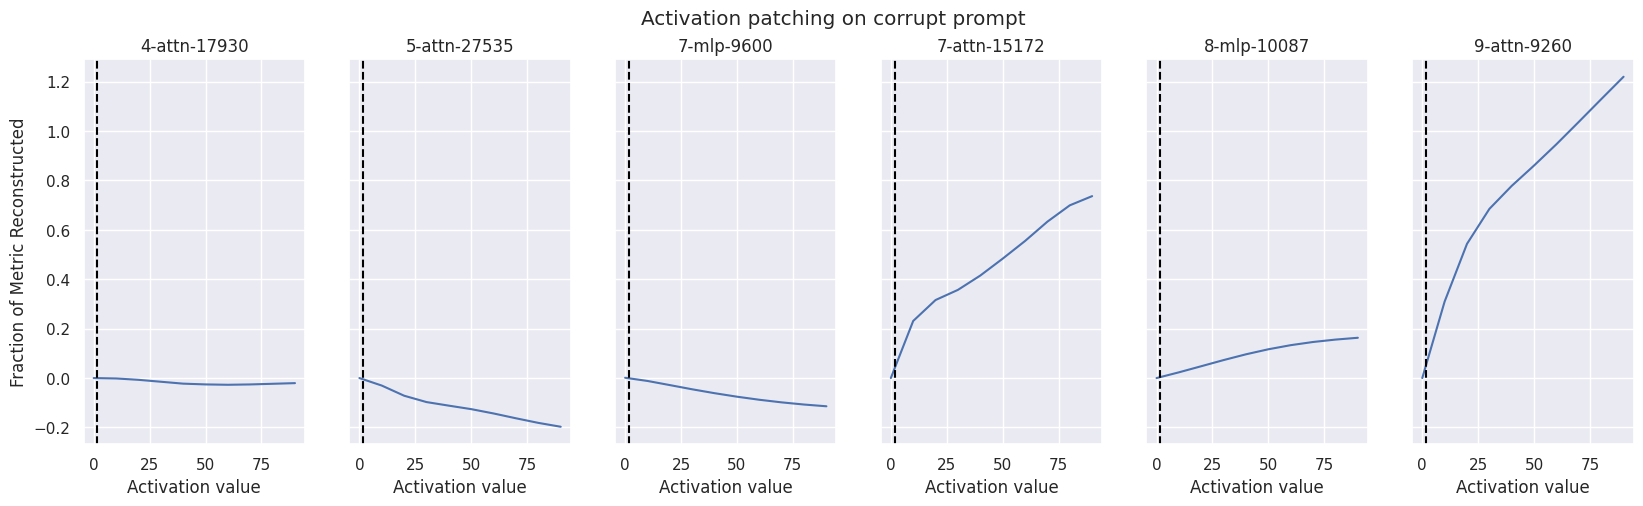

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, axs = plt.subplots(nrows = 1, ncols = len(results), figsize = (20, 5), sharey=True)
for (name, (values, metrics)), ax in zip(results.items(), axs):
    sns.lineplot(x = values, y = metrics, ax = ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Activation value")
    ax.set_ylabel("Fraction of Metric Reconstructed")
    ax.axvline(clean_node_val, ls = '--', color='black')
    print(corrupted_str)
fig.suptitle("Activation patching on corrupt prompt")

# Noising Results


In [63]:
results = {}

for name, node in nodes_of_interest.items():
    values, metrics = get_node_patching_plot(node, model, clean_tokens, -np.arange(10) * 10)
    results[name] = (values, metrics)

<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param
<|endoftext|>
def table(self, mode, array, base, date, call, parent):
    """suit fight resident

    :param code: force disk
    :param node: press joy
    :param


Text(0.5, 0.98, 'Activation patching on clean prompt')

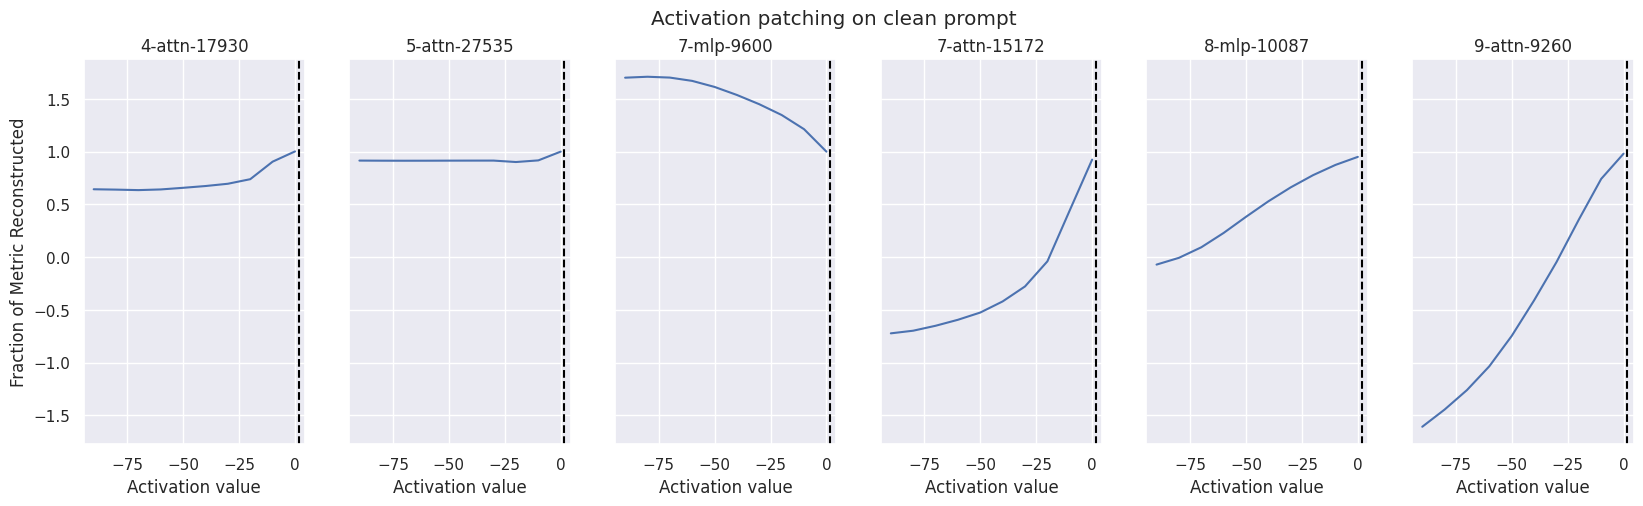

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, axs = plt.subplots(nrows = 1, ncols = len(results), figsize = (20, 5), sharey=True)
for (name, (values, metrics)), ax in zip(results.items(), axs):
    sns.lineplot(x = values, y = metrics, ax = ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Activation value")
    ax.set_ylabel("Fraction of Metric Reconstructed")
    ax.axvline(clean_node_val, ls = '--', color='black')
    print(corrupted_str)
fig.suptitle("Activation patching on clean prompt")

In [65]:
# Input-invariant connections to downstream features? 
# NOTE: This interacts with the QK circuit in a way I don't understand yet... 


# l7_node_w_dec = transcoders[7].W_dec[feature_idx]
# W_enc = attn_saes[9].W_enc
# W_Q = model.blocks[9].attn.W_Q
# W_K = model.blocks[9].attn.W_K
# print(att_9_W_enc.shape)

# dot_prods = l7_node_w_dec @ att_9_W_enc 
# print(dot_prods)
# norms = att_9_W_enc.norm(dim=0)
# print(norms)

# cos_sims = dot_prods / (norms + 1e-6)

# sns.histplot(cos_sims.detach().cpu().numpy())

In [66]:
# Compare the direct effect vs indirect effect through nodes? 
